# Clasificación usando redes neuronales
Para este punto se empleará el dataset numérico donde las variables categóricas se transforman en numéricas via one-hot encoding

In [ ]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [ ]:
dataset = pd.read_csv('numerico.csv')
dataset = dataset.iloc[:,1:]
print(dataset.shape)

(41090, 31)


In [ ]:
for column in ["age", "balance", "duration" , "pdays", "previous"]:
  dataset[column] = (dataset[column] - np.mean(dataset[column])) / np.std(dataset[column])
dataset = dataset[list(dataset.columns[0:13]) + list(dataset.columns[14:31]) + list(dataset.columns[13])]

dataset

,age,education,default,balance,housing,loan,contact,day,month,duration,...,student,technician,unemployed,divorced,married,single,failure,other,success,y
0,1.716911,3,0,0.613195,1,0,0,5,5,0.127278,...,0,0,0,0,1,0,1,0,0,0
1,0.332788,2,0,-0.603598,1,0,0,5,5,-0.440774,...,0,1,0,0,0,1,1,0,0,0
2,-0.754738,2,0,-0.619139,1,1,0,5,5,-0.828081,...,0,0,0,0,1,0,1,0,0,0
3,0.629385,2,0,0.246545,1,0,0,5,5,-0.745456,...,0,0,0,0,1,0,1,0,0,0
4,-0.754738,2,0,-0.619715,0,0,0,5,5,-0.198061,...,0,0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41085,-1.743397,3,0,-0.555249,0,0,0,17,11,0.153098,...,1,0,0,0,0,1,1,0,0,1
41086,-1.545665,2,0,-0.329618,0,1,0,17,11,0.772791,...,0,1,0,0,0,1,1,0,0,1
41087,1.024849,3,0,-0.145430,0,0,0,17,11,3.824775,...,0,1,0,0,1,0,1,0,0,1
41088,3.002168,1,0,0.374901,0,0,0,17,11,1.134278,...,0,0,0,1,0,0,1,0,0,1


In [ ]:
dataset = dataset.drop("duration" , axis=1)

Se toma una muestra balanceada de tamaño 8204, con todos los 4102 registros de clientes que aceptaron el depósito a término y 4102 registros escogidos aleatoriamente entre los que no aceptaron, luego sobre esa muestra se toman los conjuntos de entrenamiento y prueba con una proporción 70/30 respectivamente.


In [ ]:
group_sample_size = sum(dataset["y"] == 1)
balanced_dataset = dataset.groupby("y", group_keys=False).apply(lambda x: x.sample(group_sample_size))
X  = balanced_dataset.iloc[:,:-1]
y = balanced_dataset.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

Se crea una red neuronal con dos capas intermedias, de 60 y 30 neuronas respectivamente, con función de activación relu. La capa de salida consiste de una única neurona cuya función de activación es sigmoide, para determinar la probabilidad de que el cliente adquiera el depósito.

In [ ]:
model = tf.keras.models.Sequential(
    [
        #tf.keras.layers.InputLayer(input_shape=(30,)),
        tf.keras.layers.InputLayer(input_shape=(29,)),
        tf.keras.layers.Dense(60, activation="relu"),
        tf.keras.layers.Dense(30, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ]
)

Dado que el resultado es binario se usa la función de pérdida de crosentropía binaria

In [ ]:
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

Se entrena el modelo con los datos de entrenamiento y 50 epochs

In [ ]:
model.fit(X_train,y_train, epochs=100)

Epoch 1/100
180/180 [==============================] - 2s 3ms/step - loss: 0.6444 - accuracy: 0.6242
Epoch 2/100
180/180 [==============================] - 0s 2ms/step - loss: 0.6087 - accuracy: 0.6712
Epoch 3/100
180/180 [==============================] - 0s 2ms/step - loss: 0.5948 - accuracy: 0.6804
Epoch 4/100
180/180 [==============================] - 1s 4ms/step - loss: 0.5876 - accuracy: 0.6919
Epoch 5/100
180/180 [==============================] - 1s 5ms/step - loss: 0.5833 - accuracy: 0.6897
Epoch 6/100
180/180 [==============================] - 0s 2ms/step - loss: 0.5772 - accuracy: 0.6991
Epoch 7/100
180/180 [==============================] - 0s 2ms/step - loss: 0.5730 - accuracy: 0.7001
Epoch 8/100
180/180 [==============================] - 0s 2ms/step - loss: 0.5707 - accuracy: 0.6992
Epoch 9/100
180/180 [==============================] - 0s 2ms/step - loss: 0.5662 - accuracy: 0.7015
Epoch 10/100
180/180 [==============================] - 0s 2ms/step - loss: 0.5651 - accura

Se encuentran las probabilidades de que los clientes del conjunto de prueba adquieran el depósito

In [ ]:
prediction_probabilities =  model.predict(X_test)

77/77 [==============================] - 0s 1ms/step


Se define un umbral de corte para determinar si el cliente adquiere el servicio. Si la probabilidad de que lo adquiera es mayor a 0.5, se interpreta como que el cliente lo va a hacer, de lo contrario se interpreta como si no. Posteriormente se imprime la matriz de confusión

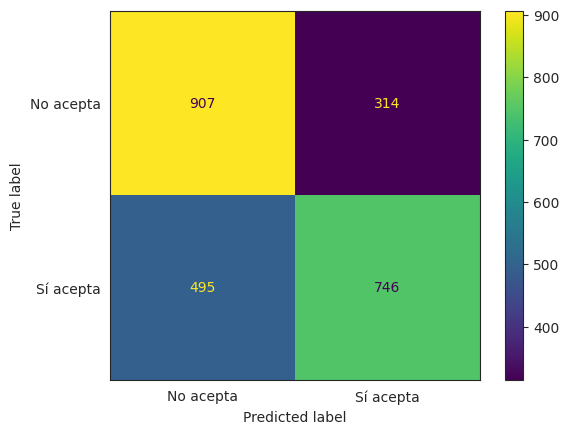

In [ ]:
import matplotlib.pyplot as plt

y_predicted = (prediction_probabilities >= 0.5).astype("int")
cm =confusion_matrix(y_test, y_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm , display_labels=["No acepta", "Sí acepta"])
disp.plot()
plt.show()

La precisión, sensibilidad, especificidad y f1-score para el modelo, prediciendo sobre el conjunto de prueba, son:

In [ ]:
accuracy = (cm[0,0] + cm[1,1]) / (y_predicted.shape[0])
sensitivity = cm[1,1] / (cm[1,0] + cm[1,1])
specificity = cm[0,0] / (cm[0,0] + cm[0,1])
precision = cm[1,1] / (cm[0,1] + cm[1,1])
f1_score = 2 * (precision*sensitivity) /(precision+sensitivity)

print(f"Exactitud: {accuracy: .3f}" )
print(f"Sensibilidad: {sensitivity: .3f}" )
print(f"Especificidad: {specificity: .3f}" )
print(f"f1-score: {f1_score: .3f}" )


Exactitud:  0.671
Sensibilidad:  0.601
Especificidad:  0.743
f1-score:  0.723


Fe de erratas:
El f1-score de la anterior celda está mal calculado, en verdad f1_score = 0.648

Se observa que se obtienen buenos puntajes sobre el conjunto de prueba. Ahora la curva ROC es la siguiente

[Text(0.5, 1.0, 'Curva ROC')]

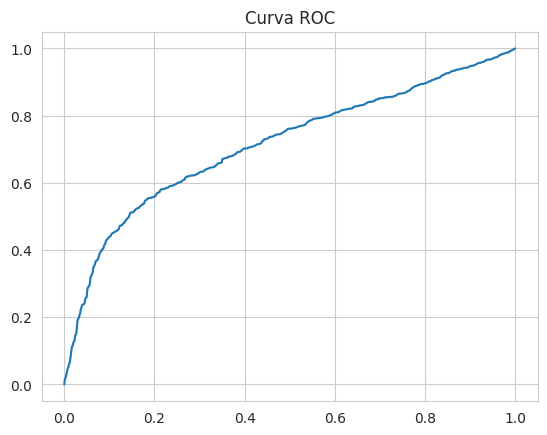

In [ ]:
import seaborn as sns
roc = roc_curve(y_test, prediction_probabilities)

sns.set_style("whitegrid")
sns.lineplot( x = roc[0], y = roc[1]).set(title='Curva ROC')
#plt.plot(roc[0] , roc[1])

El valor bajo la curva roc es:

In [ ]:
auc = roc_auc_score(y_test, prediction_probabilities)
print(f"AUC: {auc:.3f}")

AUC: 0.714


Evaluando el modelo sobre el conjunto de datos numérico original (sobre el que se hizo la muestra):

1285/1285 [==============================] - 3s 2ms/step


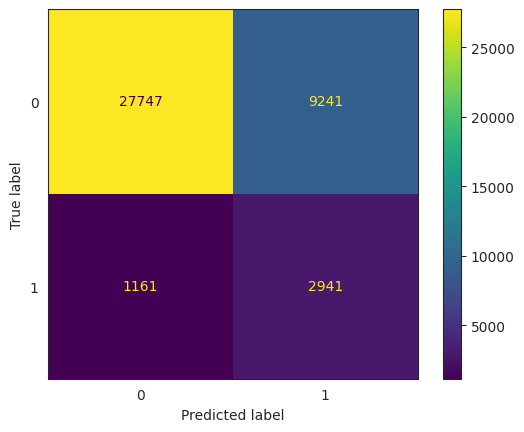

In [ ]:
X = dataset.iloc[:,0:-1]
y = dataset.iloc[:,-1]

sns.set_style("white")
y_predicted_all_probabilities =  model.predict(X)
y_predicted_all = (y_predicted_all_probabilities >= 0.5).astype("int")
cm =confusion_matrix(y, y_predicted_all)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
accuracy = (cm[0,0] + cm[1,1]) / (y_predicted_all_probabilities.shape[0])
sensitivity = cm[1,1] / (cm[1,0] + cm[1,1])
specificity = cm[0,0] / (cm[0,0] + cm[0,1])
precision = cm[1,1] / (cm[0,1] + cm[1,1])
recall = cm[0,0] / (cm[0,0] + cm[0,1])
f1_score = 2 * (precision*recall) /(precision+recall)

print(f"Exactitud: {accuracy: .3f}" )
print(f"Sensibilidad: {sensitivity: .3f}" )
print(f"Especificidad: {specificity: .3f}" )
print(f"f1-score: {f1_score: .3f}" )

Exactitud:  0.747
Sensibilidad:  0.717
Especificidad:  0.750
f1-score:  0.365


Se observa que el f1-score disminuyó, pero las demás medidas se mantuvieron en valores cercanos a los originales.

[Text(0.5, 1.0, 'Curva ROC')]

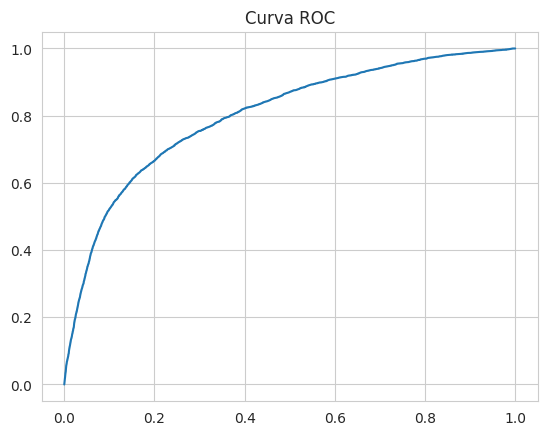

In [ ]:
roc = roc_curve(y, y_predicted_all_probabilities)

sns.set_style("whitegrid")
sns.lineplot( x = roc[0], y = roc[1]).set(title='Curva ROC')

In [ ]:
auc = roc_auc_score(y, y_predicted_all_probabilities)
print(f"AUC: {auc:.3f}")

AUC: 0.914


Se observa que el valor de AUC aumentó respecto al conjunto de prueba.